# Calculating odds and probabilities of mRS-level outcomes after stroke, based on time to reperfusion treatment

In this notebook we explain the simplest way to find probability and odds depending on time to treatment that will be used in predicting modified Rankin Scale (mRS) after stroke.

## Plain English summary

We have [previously derived](https://github.com/samuel-book/stroke_outcome/blob/main/mrs_datasets_full.ipynb) the probabilities of mRS at time zero, $t=0\,$hr, and the time of no effect, $t=t_{\mathrm{ne}}$.
We need to use the data we have at these two fixed times to create a model that describes probability at any time $t$.

Since we know that probability, odds, and log(odds) are all linked, __TO DO: link to some intro notebook__
we can find the outcomes for just one of these measures and then convert the outcomes into any of the other measures.

We'll find the outcomes for log(odds) because these are the easiest to calculate. In the literature, the log(odds ratio) has been presented at regular time intervals and falls off approximately linearly with time $t$. This allows it to be modelled as a straight line.

> ![](../images/odds_decay.png)
> 
> The right-hand plot shows the falling log-odds ratio with time. It uses data for thrombolysis from Emberson et al. 2014 and data for thrombectomy from Fransen et al. 2016.

We'll then convert the outcomes from log(odds) into probability.

## Method

The steps here are, for mRS$\leq$5$^*$:
1. Define log(odds) with time as a straight line.
2. Find the proportion of time to onset to time of no effect that matches the time to treatment. 
5. Take the same proportion from the log-odds at time of onset to the log-odds at time of no effect. This is the log-odds at time of treatment.
6. Convert the log-odds to probability.
7. Repeat this for the other mRS bands to find the mRS distribution at the time of treatment.

$^*$ We cannot include mRS$\leq$6 in these calculations, but luckily we already know that $P(\mathrm{mRS}\leq6)=1.0$ at all $t$.


Note: in this document we calculate log(odds) instead of log(odds radio) like in the plot above. It doesn't make any difference to the final result.
The log(odds ratio) is used so that it is clear at what time the log(odds ratio) falls below zero, and so when to define the time of no effect. 
Since we are using data where we already know this time of no effect and the probability distributions at that time, we can skip a step and directly model log(odds) as a straight line. 
We can make this simplification because the straight line fits to log(odds) and to log(odds ratio) share a gradient and only differ in their start and end values (their displacement in $y$). 

# Notebook admin

In [1]:
# Keep notebook cleaner once finalised
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Set up MatPlotLib
%matplotlib inline
# Change default colour scheme:
plt.style.use('seaborn-colorblind')

# Collect the data

We'll use the data for large-vessel occlusions (LVOs) that are treated with mechanical thrombectomy (MT), using the same probability distributions that we've defined in [this notebook](https://github.com/samuel-book/stroke_outcome/blob/main/mrs_datasets_full.ipynb). 

Define the time of no effect $t_{\mathrm{ne}}$ for LVOs treated with MT: 

In [4]:
t_0 = 0.0 # hours
t_ne = 8.0 # hours

Load mRS distributions of probabilities in each bin, $P(\mathrm{mRS}=x)$:

In [5]:
mrs_prob_all = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_bins.csv', index_col='Stroke type')

mrs_prob_all

,0,1,2,3,4,5,6
Stroke type,,,,,,,
pre_stroke_nlvo,0.582881,0.162538,0.103440,0.102223,0.041973,0.006945,0.000000
pre_stroke_nlvo_ivt_deaths,0.576469,0.160750,0.102302,0.101099,0.041511,0.006869,0.011000
pre_stroke_lvo,0.417894,0.142959,0.118430,0.164211,0.113775,0.042731,0.000000
pre_stroke_lvo_ivt_deaths,0.403644,0.138084,0.114392,0.158611,0.109895,0.041274,0.034100
pre_stroke_lvo_mt_deaths,0.401178,0.137241,0.113693,0.157643,0.109224,0.041022,0.040000
no_treatment_nlvo,0.197144,0.262856,0.120032,0.127736,0.147909,0.062025,0.082298
no_effect_nlvo_ivt_deaths,0.197271,0.262729,0.117583,0.124669,0.142991,0.059211,0.095546
t0_treatment_nlvo_ivt,0.429808,0.200192,0.108212,0.110215,0.080760,0.027113,0.043700
no_treatment_lvo,0.050000,0.079000,0.136000,0.164000,0.247000,0.135000,0.189000


Cumulative probabilities, $P(\mathrm{mRS}\leq x))$:

In [6]:
mrs_cprob_all = pd.read_csv(
    './outcome_utilities/mrs_dist_probs_cumsum.csv', index_col='Stroke type')

mrs_cprob_all

,0,1,2,3,4,5,6
Stroke type,,,,,,,
pre_stroke_nlvo,0.582881,0.745419,0.848859,0.951082,0.993055,1.000000,1.0
pre_stroke_nlvo_ivt_deaths,0.576469,0.737219,0.839522,0.940620,0.982131,0.989000,1.0
pre_stroke_lvo,0.417894,0.560853,0.679283,0.843494,0.957269,1.000000,1.0
pre_stroke_lvo_ivt_deaths,0.403644,0.541728,0.656119,0.814731,0.924626,0.965900,1.0
pre_stroke_lvo_mt_deaths,0.401178,0.538419,0.652112,0.809754,0.918978,0.960000,1.0
no_treatment_nlvo,0.197144,0.460000,0.580032,0.707768,0.855677,0.917702,1.0
no_effect_nlvo_ivt_deaths,0.197271,0.460000,0.577583,0.702252,0.845244,0.904454,1.0
t0_treatment_nlvo_ivt,0.429808,0.630000,0.738212,0.848427,0.929188,0.956300,1.0
no_treatment_lvo,0.050000,0.129000,0.265000,0.429000,0.676000,0.811000,1.0


Pick out the data we want here. In this example we will use the data for LVO patients treated with MT.

In [7]:
t0_st = 't0_treatment_lvo_mt'
ne_st = 'no_effect_lvo_mt_deaths'

mrs_prob_t0 = mrs_prob_all.loc[t0_st].values
mrs_prob_ne = mrs_prob_all.loc[ne_st].values

mrs_cprob_t0 = mrs_cprob_all.loc[t0_st].values
mrs_cprob_ne = mrs_cprob_all.loc[ne_st].values

Convert probability to odds:

In [8]:
mrs_odds_cumsum_t0 = mrs_cprob_t0 / (1.0 - mrs_cprob_t0)
mrs_odds_cumsum_ne = mrs_cprob_ne / (1.0 - mrs_cprob_ne)

# Manually set mRS<=6 values to infinity, since P(mRS<=6)=1:
mrs_odds_cumsum_t0[-1] = np.inf 
mrs_odds_cumsum_ne[-1] = np.inf

Convert odds to log(odds):

In [9]:
mrs_logodds_cumsum_t0 = np.log(mrs_odds_cumsum_t0)
mrs_logodds_cumsum_ne = np.log(mrs_odds_cumsum_ne)

## Plot the known data

The following two cells define some colours and a plotting function that we'll use here and later in the notebook:

In [10]:
colour_list = np.array([
    '#0072B2', '#009E73', '#D55E00', '#CC79A7',
    '#F0E442', '#56B4E9', 'DarkSlateGray'], dtype='<U13'
)

In [11]:
def plot_three_with_time(ylabels, data_lists):
    fig, axs = plt.subplots(1,3, figsize=(15,5), gridspec_kw={'wspace':0.3})
    for d,data_list in enumerate(data_lists):
        ax = axs[d]
        ax.grid()
        d_t0 = data_list[0]
        d_no = data_list[1]
        for i in range(6):
            ax.scatter([0.0,t_ne], [d_t0[i],d_no[i]],
                       color=colour_list[i], edgecolor='k', 
                       label=f'$\leq${i}', zorder=3)

        ax.set_ylabel(ylabels[d].split('\n')[0])
        ax.set_title(ylabels[d], fontsize=15)
        ax.set_xticks(np.arange(0,t_ne+1,1))
        ax.set_xlabel('Onset to treatment time (hours)')
        if d==1:
            ax.legend(loc='upper center', bbox_to_anchor=[0.5, -0.15], 
                      ncol=7, title='mRS')

    axs[0].set_ylim(0.0, 1.0)
    # axs[1].set_ylim(0.0, 11.5)
    axs[2].axhline(0.0, color='k', linewidth=1)
    return fig, axs

This cell produces the plot of probability, odds, and log(odds):

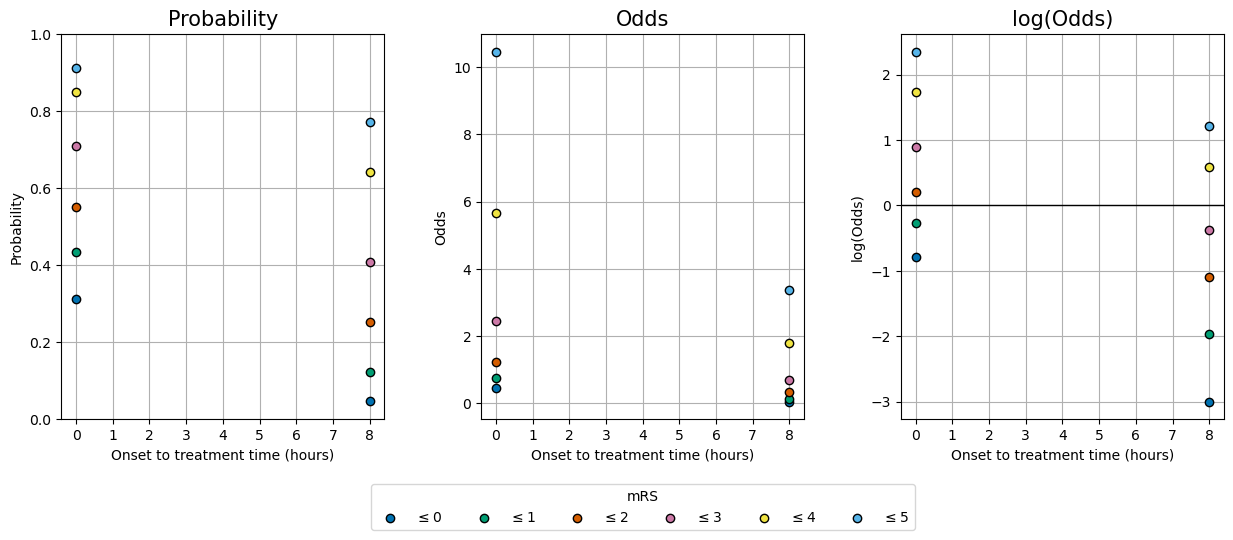

In [12]:
data_lists = [
    [mrs_cprob_t0, mrs_cprob_ne],
    [mrs_odds_cumsum_t0, mrs_odds_cumsum_ne],
    [mrs_logodds_cumsum_t0, mrs_logodds_cumsum_ne]
    ]

ylabels = ['Probability', 'Odds', 'log(Odds)']

fig, axs = plot_three_with_time(ylabels, data_lists)

# plt.savefig('./images/time_varying_probs_odds_logodds_data-only.jpg', 
#             dpi=300, bbox_inches='tight')
plt.show()

Now, for each graph we need to connect the two sets of data at $t=0$ and the no-effect time by finding out how probability, odds and log(odds) vary with time. 

## Calculate log-odds proportions

Pick out the data for mRS<=5 (the top points in the charts).

In [36]:
t0_logodds = mrs_logodds_cumsum_t0[5]
no_effect_logodds = mrs_logodds_cumsum_ne[5]

t0_logodds, no_effect_logodds

(2.347684459453209, 1.21396637000909)

Pick a treatment time:

In [37]:
t_treat = 2.0  # hours

Find the proportion of time from onset to no effect:

In [38]:
frac_to_no_effect = (t_treat - t_0) / (t_ne - t_0)

frac_to_no_effect

0.25

Take this proportion from the starting to the end log-odds:

In [39]:
treated_logodds = t0_logodds - (frac_to_no_effect * (t0_logodds - no_effect_logodds))

treated_logodds

2.064254937092179

Plot this quickly to show how the proportions work:

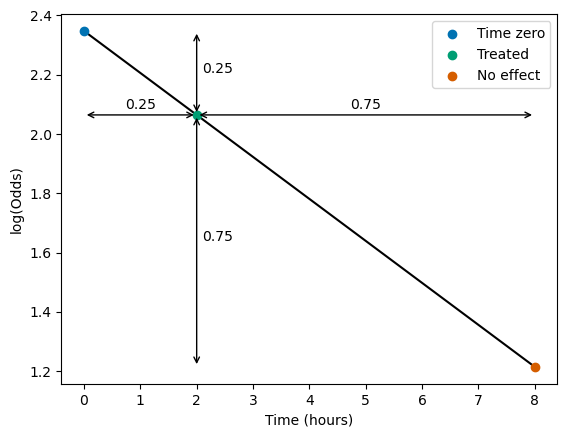

In [68]:
plt.plot([t_0, t_ne], [t0_logodds, no_effect_logodds], color='k', zorder=0)
plt.scatter(t_0, t0_logodds, label='Time zero')
plt.scatter(t_treat, treated_logodds, label='Treated')
plt.scatter(t_ne, no_effect_logodds, label='No effect')

ad = dict(arrowstyle='<->')

# Horizontal arrows and labels:
plt.annotate('', xy=(t_0, treated_logodds),
             xytext=(t_treat, treated_logodds),
             arrowprops=ad)
plt.annotate(f'{frac_to_no_effect}',
             xy=(0.5 * t_treat, treated_logodds * 1.01),
             ha='center')

plt.annotate('', xy=(t_treat, treated_logodds),
             xytext=(t_ne, treated_logodds),
             arrowprops=ad)
plt.annotate(f'{1.0 - frac_to_no_effect}',
             xy=(t_treat + 0.5 * (t_ne - t_treat), treated_logodds * 1.01),
             ha='center')

# Vertical arrows and labels:
plt.annotate('', xy=(t_treat, t0_logodds),
             xytext=(t_treat, treated_logodds), arrowprops=ad)
plt.annotate(f'{frac_to_no_effect}',
             xy=(t_treat + 0.1, treated_logodds + 0.5 * (t0_logodds - treated_logodds)), ha='left')

plt.annotate('', xy=(t_treat, treated_logodds),
             xytext=(t_treat, no_effect_logodds), arrowprops=ad)
plt.annotate(f'{1.0 - frac_to_no_effect}',
             xy=(t_treat + 0.1, no_effect_logodds + 0.5 * (treated_logodds - no_effect_logodds)), ha='left')

plt.xlabel('Time (hours)')
plt.ylabel('log(Odds)')
plt.legend()
plt.show()

Finally, convert the treated log-odds to odds...

In [17]:
treated_odds = np.exp(treated_logodds)

treated_odds

6.838306928429508

... and these odds to probability:

In [18]:
treated_probs = treated_odds / (1 + treated_odds)

treated_probs

0.872421428615789

This is the probability of mRS$\leq$5 at the chosen treatment time.

By repeating this for all mRS values, we can find the mRS distribution at this treatment time:

In [19]:
treated_logodds = (
    mrs_logodds_cumsum_t0 - (frac_to_no_effect * (mrs_logodds_cumsum_t0 - mrs_logodds_cumsum_ne))
)

treated_odds = np.exp(treated_logodds)

treated_probs = treated_odds / (1 + treated_odds)

In [20]:
treated_probs

array([0.16574163, 0.28850692, 0.431069  , 0.60290449, 0.78646085,
       0.87242143,        nan])

The final value is `nan`, Not A Number, because mRS$\leq$6 always has a probability of 1 and so cannot be converted into log-odds and back. When working with mRS$\leq$6 we can just manually change any invalid probabilities to 1 at the end of the calculations.

## stroke-outcome package

The `stroke-outcome` package includes the following function to calculate the probability at a given treatment time.

In [21]:
from stroke_outcome.outcome_utilities import calculate_mrs_dist_at_treatment_time

Display the contents of the function:

In [22]:
calculate_mrs_dist_at_treatment_time??

Signature:
calculate_mrs_dist_at_treatment_time(
    time_to_treatment_mins: Union[numpy.__array_like._SupportsArray[numpy.dtype[Any]], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    time_no_effect_mins: float,
    t0_logodds: Union[numpy.__array_like._SupportsArray[numpy.dtype[Any]], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    no_effect_logodds: Union[numpy.__array_like._SupportsArray[numpy.dtype[Any]], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    final_va

.

Check that this gives the same results as for earlier in this document:

In [25]:
treated_probs_before = treated_probs.copy()

In [23]:
treated_probs, treated_odds, treated_logodds = calculate_mrs_dist_at_treatment_time(
        time_to_treatment_mins = t_treat,
        time_no_effect_mins = t_ne,
        t0_logodds = mrs_logodds_cumsum_t0,
        no_effect_logodds = mrs_logodds_cumsum_ne,
        final_value_is_mrs6 = True
        )

In [27]:
treated_probs

array([0.16574163, 0.28850692, 0.431069  , 0.60290449, 0.78646085,
       0.87242143, 1.        ])

In [26]:
treated_probs == treated_probs_before

array([ True,  True,  True,  True,  True,  True,  True])

## Plot the time distributions

The following cell draws the same graphs as before, and now adds the variations with time.

The function from the `stroke-outcome` package is used to calculate the probability distributions at very many times between time zero and the time of no effect so that on the final graphs it looks like a continuous change.

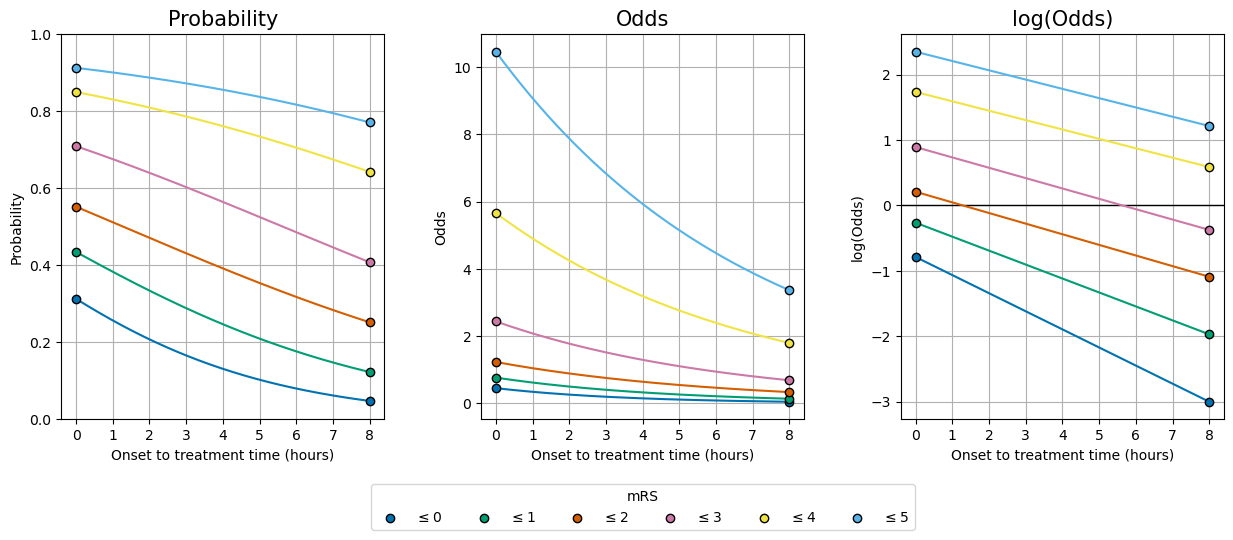

In [33]:
ylabels = ['Probability', 'Odds', 'log(Odds)']

# Use these logodds:
t0_logodds = mrs_logodds_cumsum_t0
no_effect_logodds = mrs_logodds_cumsum_ne

# This time-of-no-effect:
t_ne = 8.0  # hours

# Plot over this time range:
t = np.arange(0, t_ne*60.0 + 0.1, 0.1)

# Reshape the arrays to allow for multiple treatment times.
time_to_treatment_mins = t.reshape(len(t), 1)
no_effect_logodds = no_effect_logodds.reshape(1, len(no_effect_logodds))
t0_logodds = t0_logodds.reshape(1, len(t0_logodds))

treated_probs, treated_odds, treated_logodds = calculate_mrs_dist_at_treatment_time(
    time_to_treatment_mins = time_to_treatment_mins,
    time_no_effect_mins = t_ne * 60.0,
    t0_logodds = t0_logodds,
    no_effect_logodds = no_effect_logodds,
    final_value_is_mrs6 = True
    )

# Make the same plot as earlier...
fig, axs = plot_three_with_time(ylabels, data_lists)

# ... and now add lines to connect the starting data points: 
for d, ax in enumerate(axs):
    for i in range(6):
        if d==0: # Probability:
            yvals = treated_probs[:, i]
        elif d==1: # Odds:
            yvals = treated_odds[:, i]
        else: # log(odds):
            yvals = treated_logodds[:, i]
        ax.plot(t / 60.0, yvals, color=colour_list[i], zorder=2)
            
# plt.savefig('./images/time_varying_probs_odds_logodds.jpg', 
#             dpi=300, bbox_inches='tight')
plt.show()

__Success!__ We started with the data at t=0 and t=$t_{\mathrm{ne}}$ (8 hours) and have calculated the lines in between.

# References

Emberson J, Lees KR, Lyden P, et al. Effect of treatment delay, age, and stroke severity on the effects of intravenous thrombolysis with alteplase for acute ischaemic stroke: A meta-analysis of individual patient data from randomised trials. The Lancet 2014;384:1929–35. doi:10.1016/S0140-6736(14)60584-5

Fransen PSS, Berkhemer OA, Lingsma HF, et al. Time to Reperfusion and Treatment Effect for Acute Ischemic Stroke: A Randomized Clinical Trial. JAMA Neurol 2016;73:190–6. doi:10.1001/jamaneurol.2015.3886